# Compare Twitter and Reddit Populations

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform.
The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [1]:
%matplotlib inline

In [2]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
import sklearn.preprocessing
import sklearn.metrics

In [4]:
from utils.youtube import strip_video_id_from_url

In [5]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")

def convert_time(timestamp):
    created_time = timestamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

def get_top_tlds(links_df, user_id_field, top_n=100):
    tld_user_counts = {}
    for tld, group in links_df.groupby("tld"):
        local_users = set(group[user_id_field])
        tld_user_counts[tld] = len(local_users)

    return sorted(tld_user_counts, key=tld_user_counts.get, reverse=True)[:top_n]

def links_df_to_shares(links_df, domains, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + domains)

def links_to_norm_matrix(links_df, domains, user_id_field):
    if ( type(domains) == set ):
        domains = list(domains)
        
    shares_df = links_df_to_shares(links_df, domains, user_id_field)
    return sklearn.preprocessing.normalize(shares_df[domains], norm="l2", axis=1)

def get_top_channels(yt_df, user_id_field, top_n=100):
    channel_user_counts = {}
    for channel, group in yt_df.groupby("channel_id"):
        local_users = set(group[user_id_field])
        channel_user_counts[channel] = len(local_users)

    return sorted(channel_user_counts, key=channel_user_counts.get, reverse=True)[:top_n]

def channels_df_to_shares(links_df, channels, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_chan_counts = dict(user_posts["channel_id"].value_counts().items())
        local_vector = [local_chan_counts.get(x, 0) for x in channels]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + channels)

def channels_to_norm_matrix(links_df, channels, user_id_field):
    if ( type(channels) == set ):
        channels = list(channels)
        
    shares_df = channels_df_to_shares(links_df, channels, user_id_field)
    return sklearn.preprocessing.normalize(shares_df[channels], norm="l2", axis=1)


In [6]:
political_domains_df = pd.read_csv("DomainIdeology.csv")
political_domains = set(political_domains_df["domain"].apply(str.lower))
print("Political Domains:", len(political_domains))

Political Domains: 145


In [7]:
top_n_domains = 150
top_n_channels = 250
bootstrap_count = 5000

In [8]:
short_domain_map = {
    "abcn.ws": "abcnews.go.com",
    "amzn.to": "amazon.com",
    "apne.ws": "apnews.com",
    "apple.co": "apple.com",
    "bbc.in": "bbc.com",
    "ble.ac": "bleacherreport.com",
    "bloom.bg": "bloomberg.com",
    "bzfd.it": "buzzfeed.com",
    "cbsloc.al": "cbslocal.com",
    "cnb.cx": "cnbc.com",
    "cnn.it": "cnn.com",
    "cnn.it": "cnn.com",
    "dailym.ai" : "dailymail.co.uk",
    "econ.st": "economist.com",
    "es.pn": "espn.com",
    "fxn.ws": "foxnews.com",
    "hill.cm": "thehill.com",
    "huff.to" : "huffingtonpost.com",
    "lat.ms": "latimes.com",
    "lnkd.in": "linkedin.com",
    "n.pr": "npr.org",
    "nbcnews.to": "nbcnews.com",
    "nydn.us": "nydailynews.com",
    "nyp.st": "nypost.com",
    "nyti.ms": "nytimes.com",
    "on.rt.com": "rt.com",
    "on.wsj.com": "wsj.com",
    "politi.co": "politico.com",
    "redd.it": "reddit.com",
    "reut.rs": "reuters.com",
    "thebea.st": "thedailybeast.com",
    "ti.me": "time.com",
    "tmblr.co": "tumblr.com",
    "usat.ly": "usatoday.com",
    "wapo.st": "washingtonpost.com",
    "wp.me": "wordpress.com",
    "wpo.st": "washingtonpost.com",
    "yhoo.it": "yahoo.com",
    "youtu.be": "youtube.com",
}

In [9]:
twitter_links_df_rand = pd.read_csv("twitter_random_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_poli = pd.read_csv("twitter_political_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_ira = pd.read_csv(
    "twitter_ira_links.csv",
    converters={"created_at": lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")}
)

In [10]:
twitter_links_df_rand["tld"] = twitter_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_poli["tld"] = twitter_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_ira["tld"] = twitter_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [11]:

twitter_top_tlds_rand = get_top_tlds(twitter_links_df_rand, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_poli = get_top_tlds(twitter_links_df_poli, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_ira = get_top_tlds(twitter_links_df_ira, user_id_field="user_id", top_n=top_n_domains)

top_tld_map_twitter = {
    "random": set(twitter_top_tlds_rand),
    "political": set(twitter_top_tlds_poli),
    "ira": set(twitter_top_tlds_ira),
}

for population, tlds in top_tld_map_twitter.items():
    print(population, ":", len(tlds))

# twitter_merged_tlds = set(twitter_top_tlds_rand)\
#     .intersection(twitter_top_tlds_poli)
# #     .intersection(twitter_top_tlds_ira)
# print("Merged Top TLDs:", len(twitter_merged_tlds))


random : 150
political : 150
ira : 150


In [12]:
reddit_links_df_rand = pd.read_csv("reddit_random_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_poli = pd.read_csv("reddit_political_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_ira = pd.read_csv("reddit_troll_links.csv",
    converters={"created_at": convert_time}
)

In [13]:
reddit_links_df_rand["tld"] = reddit_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_poli["tld"] = reddit_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_ira["tld"] = reddit_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [14]:

reddit_top_tlds_rand = get_top_tlds(reddit_links_df_rand, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_poli = get_top_tlds(reddit_links_df_poli, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_ira = get_top_tlds(reddit_links_df_ira, user_id_field="user_name", top_n=top_n_domains)

top_tld_map_reddit = {
    "random": set(reddit_top_tlds_rand),
    "political": set(reddit_top_tlds_poli),
    "ira": set(reddit_top_tlds_ira),
}

for population, tlds in top_tld_map_reddit.items():
    print(population, ":", len(tlds))

# reddit_merged_tlds = set(reddit_top_tlds_rand)\
#     .intersection(reddit_top_tlds_poli)
# #     .intersection(reddit_top_tlds_ira)
# print("Merged Top TLDs:", len(reddit_merged_tlds))

random : 150
political : 150
ira : 150


In [ ]:
# cross_platform_tlds = twitter_merged_tlds.intersection(reddit_merged_tlds)

# # Pop off these ultra-common TLDs. 
# #. The motivation here is that twitter.com is injected 
# #.  when a Twitter user retweets, and sharing within 
# #.  Reddit through crossposting increases its prevalence.
# #.  These phenomena will make activity across populations
# #.  appear artificially more similar than they ought to be.
# # cross_platform_tlds.remove("twitter.com")
# # cross_platform_tlds.remove("reddit.com")

# print("Cross-Platform Top TLDs:", len(cross_platform_tlds))

In [ ]:
# print("Cross-Platform TLDs:")
# for x in sorted(cross_platform_tlds):
#     print("\t", x)

In [ ]:
# print("TLDs in Reddit but not Twitter:")
# for tld in sorted(reddit_merged_tlds.difference(twitter_merged_tlds)):
#     print("\t", tld)

In [ ]:
# print("TLDs in Twitter but not Reddit:")
# for tld in sorted(twitter_merged_tlds.difference(reddit_merged_tlds)):
#     print("\t", tld)

In [92]:
# Use the following to test whether focusing only on political domains 
#. changes outcomes
top_tld_map_twitter = {k: political_domains for k in top_tld_map_twitter}
top_tld_map_reddit = {k: political_domains for k in top_tld_map_reddit}

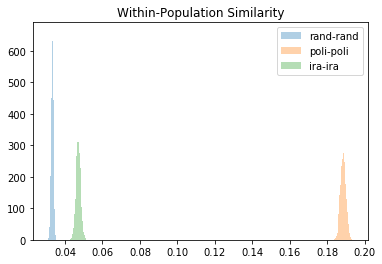

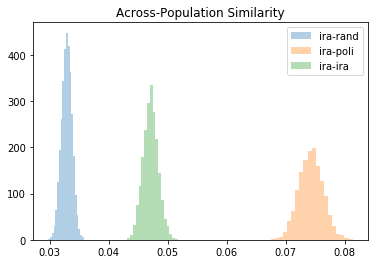

In [93]:
twitter_overlap_rand_poli = top_tld_map_twitter["random"].intersection(top_tld_map_twitter["political"])
twitter_overlap_rand_ira = top_tld_map_twitter["random"].intersection(top_tld_map_twitter["ira"])
twitter_overlap_poli_ira = top_tld_map_twitter["political"].intersection(top_tld_map_twitter["ira"])

twitter_user_links_mat_rand = links_to_norm_matrix(twitter_links_df_rand, top_tld_map_twitter["random"], "user_id")
twitter_user_links_mat_poli = links_to_norm_matrix(twitter_links_df_poli, top_tld_map_twitter["political"], "user_id")
twitter_user_links_mat_ira = links_to_norm_matrix(twitter_links_df_ira, top_tld_map_twitter["ira"], "user_id")

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, twitter_overlap_rand_ira, "user_id"), 
    links_to_norm_matrix(twitter_links_df_rand, twitter_overlap_rand_ira, "user_id"))
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, twitter_overlap_poli_ira, "user_id"), 
    links_to_norm_matrix(twitter_links_df_poli, twitter_overlap_poli_ira, "user_id"))
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_rand, twitter_overlap_rand_poli, "user_id"), 
    links_to_norm_matrix(twitter_links_df_poli, twitter_overlap_rand_poli, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_ira_sim_avg = (np.sum(t2t_ira_ira_sim, axis=1) - 1) / (twitter_user_links_mat_ira.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)
t2t_rand_poli_sim_avg = np.mean(t2t_rand_poli_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(t2t_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(t2t_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(t2t_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [94]:
print("Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), np.array(t2t_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), np.array(t2t_ira_ira_sim_avg_bootstrap).var())


Random: 0.033210139542131985 3.517008769743961e-07
Political: 0.1885921017287461 2.1337795539841753e-06
Russian IRA: 0.04708511116304513 1.6411239412722253e-06


In [95]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_poli_poli_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Rand and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_poli_poli_sim_avg_bootstrap, 
    t2t_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 26869201.24231119
p-value for Welch's t-Test between Rand and IRA: 0.0 -694.926879428628
p-value for Welch's t-Test between Poli and IRA: 0.0 5149.517478427685


In [96]:
print("Random-Random:", np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), np.array(t2t_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())


Random-Random: 0.033210139542131985 3.517008769743961e-07
Russian IRA-Random: 0.03285507891357378 7.984939090737661e-07
Russian IRA-Political: 0.07429991944833271 4.110571547229148e-06


In [97]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

# t_stat, p_val = scipy.stats.ttest_ind(
#     t2t_poli_poli_sim_avg_bootstrap, 
#     t2t_ira_ira_sim_avg_bootstrap, 
#     axis=0, equal_var=False)
# print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 1618342.9551043846
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -1322.551614099042


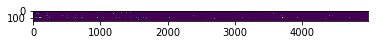

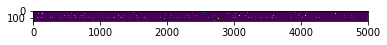

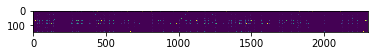

In [98]:
plt.imshow(twitter_user_links_mat_rand.T)
plt.show()
plt.imshow(twitter_user_links_mat_poli.T)
plt.show()
plt.imshow(twitter_user_links_mat_ira.T)
plt.show()

In [99]:
for label, mat in [
    ("random", twitter_user_links_mat_rand), 
    ("political", twitter_user_links_mat_poli), 
    ("ira", twitter_user_links_mat_ira)]:
    print(label)
    domains = top_tld_map_twitter[label]
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

random
	 nytimes.com 0.09794826211882986
	 cnn.com 0.0825076657429366
	 washingtonpost.com 0.05454387089410937
	 huffingtonpost.com 0.05246472480866754
	 foxnews.com 0.04188533751540307
	 usatoday.com 0.036507585679000684
	 abcnews.go.com 0.027840819891430717
	 forbes.com 0.027687450545792986
	 time.com 0.02492870675980217
	 theguardian.com 0.024790415813635704
political
	 nytimes.com 0.24809919783756695
	 washingtonpost.com 0.1673341112277779
	 cnn.com 0.1468550066218096
	 foxnews.com 0.11385267306915625
	 huffingtonpost.com 0.11370077435269438
	 thehill.com 0.09956820487481334
	 usatoday.com 0.06426377155745226
	 npr.org 0.060676624051691316
	 wsj.com 0.05521750525114148
	 breitbart.com 0.054411967942468234
ira
	 cnn.com 0.16144174198818645
	 huffingtonpost.com 0.05487354890117675
	 nytimes.com 0.05378015658812344
	 theguardian.com 0.04450972331930933
	 foxnews.com 0.04448862545359691
	 breitbart.com 0.04216861066265758
	 rt.com 0.039565310296343324
	 washingtonpost.com 0.03924306702

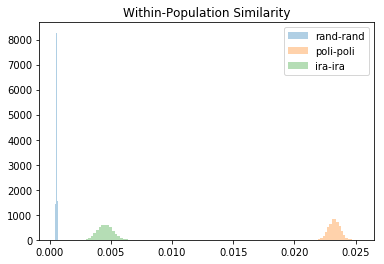

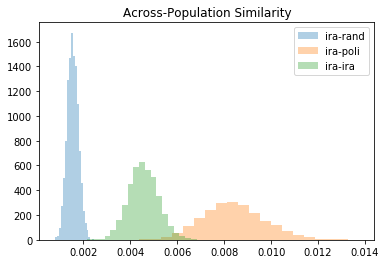

In [100]:
reddit_overlap_rand_poli = top_tld_map_reddit["random"].intersection(top_tld_map_reddit["political"])
reddit_overlap_rand_ira = top_tld_map_reddit["random"].intersection(top_tld_map_reddit["ira"])
reddit_overlap_poli_ira = top_tld_map_reddit["political"].intersection(top_tld_map_reddit["ira"])

reddit_user_links_mat_rand = links_to_norm_matrix(reddit_links_df_rand, top_tld_map_reddit["random"], "user_name")
reddit_user_links_mat_poli = links_to_norm_matrix(reddit_links_df_poli, top_tld_map_reddit["political"], "user_name")
reddit_user_links_mat_ira = links_to_norm_matrix(reddit_links_df_ira, top_tld_map_reddit["ira"], "user_name")

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, reddit_overlap_rand_ira, "user_name"), 
    links_to_norm_matrix(reddit_links_df_rand, reddit_overlap_rand_ira, "user_name"))
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, reddit_overlap_poli_ira, "user_name"), 
    links_to_norm_matrix(reddit_links_df_poli, reddit_overlap_poli_ira, "user_name"))
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_rand, reddit_overlap_rand_poli, "user_name"), 
    links_to_norm_matrix(reddit_links_df_poli, reddit_overlap_rand_poli, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_ira_sim_avg = (np.sum(r2r_ira_ira_sim, axis=1) - 1) / (reddit_user_links_mat_ira.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)
r2r_rand_poli_sim_avg = np.mean(r2r_rand_poli_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(r2r_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(r2r_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(r2r_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [101]:
print("Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Political:", np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), np.array(r2r_poli_poli_sim_avg_bootstrap).var())
print("Russian IRA:", np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), np.array(r2r_ira_ira_sim_avg_bootstrap).var())


Random: 0.0005662284746729251 2.1720997658711565e-09
Political: 0.023275211389360322 2.2545203950605262e-07
Russian IRA: 0.004570026271319696 4.036311583628085e-07


In [102]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_poli_poli_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Rand and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_poli_poli_sim_avg_bootstrap, 
    r2r_ira_ira_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 3490806.0691467836
p-value for Welch's t-Test between Rand and IRA: 0.0 -444.3814685247197
p-value for Welch's t-Test between Poli and IRA: 0.0 1667.4373913291809


In [103]:
print("Random-Random:", np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), np.array(r2r_rand_rand_sim_avg_bootstrap).var())
print("Russian IRA-Random:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-Political:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())



Random-Random: 0.0005662284746729251 2.1720997658711565e-09
Russian IRA-Random: 0.0015363661775850096 5.745654346953049e-08
Russian IRA-Political: 0.008424425660051126 1.7675274639154088e-06


In [104]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

# t_stat, p_val = scipy.stats.ttest_ind(
#     r2r_poli_poli_sim_avg_bootstrap, 
#     r2r_ira_ira_sim_avg_bootstrap, 
#     axis=0, equal_var=False)
# print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 150665.514581946
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -360.50303534205517


In [105]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(r2r_rand_rand_sim_avg_bootstrap, r2r_poli_poli_sim_avg_bootstrap, r2r_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2r_poli_poli_sim_avg_bootstrap, r2r_ira_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2r_ira_rand_sim_avg_bootstrap, r2r_ira_poli_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 3490806.0691467836
p-value for Welch's t-Test between within-Poli and within-IRA: 0.0 1667.4373913291809
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -360.50303534205517


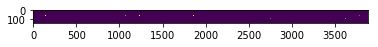

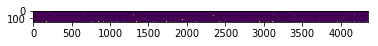

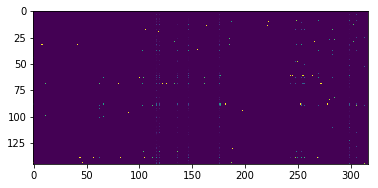

In [106]:
plt.imshow(reddit_user_links_mat_rand.T)
plt.show()
plt.imshow(reddit_user_links_mat_poli.T)
plt.show()
plt.imshow(reddit_user_links_mat_ira.T)
plt.show()

In [107]:
for label, mat in [
    ("random", reddit_user_links_mat_rand), 
    ("political", reddit_user_links_mat_poli), 
    ("ira", reddit_user_links_mat_ira)]:
    print(label)
    domains = top_tld_map_reddit[label]
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

random
	 theguardian.com 0.013904760659900078
	 nytimes.com 0.012384506728601172
	 washingtonpost.com 0.011781783027300222
	 cnn.com 0.009852697112127282
	 vice.com 0.005332514687043246
	 reuters.com 0.004794294085814836
	 huffingtonpost.com 0.004455893262661368
	 foxnews.com 0.004445968611150362
	 npr.org 0.004335171505722364
	 forbes.com 0.004101802277296389
political
	 washingtonpost.com 0.06898860071503743
	 nytimes.com 0.06617662452052485
	 cnn.com 0.05737220301401639
	 theguardian.com 0.0397492530477769
	 foxnews.com 0.037752638902656524
	 breitbart.com 0.03435783204555894
	 thehill.com 0.03016988070230979
	 politico.com 0.026409107802279615
	 reuters.com 0.02589962653041008
	 huffingtonpost.com 0.023834645791469693
ira
	 cnn.com 0.0337603626253878
	 huffingtonpost.com 0.03183903784768147
	 nytimes.com 0.02114774176598046
	 theguardian.com 0.01912915320995557
	 nbcnews.com 0.017964435169315413
	 washingtonpost.com 0.01669229900244219
	 reuters.com 0.013404720897139814
	 foxnews.c

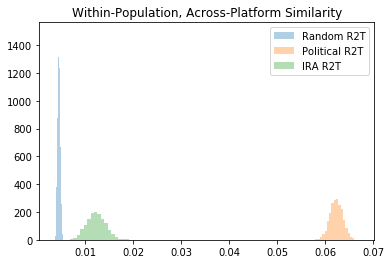

In [108]:
r2t_overlap_rand = top_tld_map_reddit["random"].intersection(top_tld_map_twitter["random"])
r2t_overlap_poli = top_tld_map_reddit["political"].intersection(top_tld_map_twitter["political"])
r2t_overlap_ira = top_tld_map_reddit["ira"].intersection(top_tld_map_twitter["ira"])

# Calculate pairwise similarity among users across platforms
# r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, twitter_user_links_mat_rand)
# r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, twitter_user_links_mat_poli)
# r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, twitter_user_links_mat_ira)

r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_rand, r2t_overlap_rand, "user_name"), 
    links_to_norm_matrix(twitter_links_df_rand, r2t_overlap_rand, "user_id"))
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_poli, r2t_overlap_poli, "user_name"), 
    links_to_norm_matrix(twitter_links_df_poli, r2t_overlap_poli, "user_id"))
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(reddit_links_df_ira, r2t_overlap_ira, "user_name"), 
    links_to_norm_matrix(twitter_links_df_ira, r2t_overlap_ira, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()


In [109]:
print("Random-R2T:", np.array(r2t_rand_sim_avg_bootstrap).mean(), np.array(r2t_rand_sim_avg_bootstrap).var())
print("Political-R2T:", np.array(r2t_poli_sim_avg_bootstrap).mean(), np.array(r2t_poli_sim_avg_bootstrap).var())
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())



Random-R2T: 0.004557978618366617 7.540260660532135e-08
Political-R2T: 0.062312058479183814 1.7355684637178517e-06
Russian IRA-R2T: 0.012325321121749047 3.794585359303397e-06


In [110]:
print("Russian IRA-T2R:", np.array(t2r_ira_sim_avg_bootstrap).mean(), np.array(t2r_ira_sim_avg_bootstrap).var())
print("Russian IRA-TRandom:", np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), np.array(t2t_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-TPoli:", np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), np.array(t2t_ira_poli_sim_avg_bootstrap).var())

Russian IRA-T2R: 0.03834851465473397 4.2697915636191657e-07
Russian IRA-TRandom: 0.03285507891357378 7.984939090737661e-07
Russian IRA-TPoli: 0.07429991944833271 4.110571547229148e-06


In [111]:
print("Russian IRA-R2T:", np.array(r2t_ira_sim_avg_bootstrap).mean(), np.array(r2t_ira_sim_avg_bootstrap).var())
print("Russian IRA-RRandom:", np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), np.array(r2r_ira_rand_sim_avg_bootstrap).var())
print("Russian IRA-RPoli:", np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), np.array(r2r_ira_poli_sim_avg_bootstrap).var())


Russian IRA-R2T: 0.012325321121749047 3.794585359303397e-06
Russian IRA-RRandom: 0.0015363661775850096 5.745654346953049e-08
Russian IRA-RPoli: 0.008424425660051126 1.7675274639154088e-06


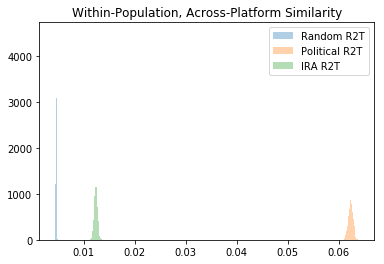

In [112]:
t2r_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_rand, r2t_overlap_rand, "user_id"), 
    links_to_norm_matrix(reddit_links_df_rand, r2t_overlap_rand, "user_name"))
t2r_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_poli, r2t_overlap_poli, "user_id"), 
    links_to_norm_matrix(reddit_links_df_poli, r2t_overlap_poli, "user_name"))
t2r_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    links_to_norm_matrix(twitter_links_df_ira, r2t_overlap_ira, "user_id"), 
    links_to_norm_matrix(reddit_links_df_ira, r2t_overlap_ira, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
t2r_rand_sim_avg = np.mean(t2r_rand_sim, axis=1)
t2r_poli_sim_avg = np.mean(t2r_poli_sim, axis=1)
t2r_ira_sim_avg = np.mean(t2r_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
t2r_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2r_rand_sim_avg, replace=True, n_samples=t2r_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2r_poli_sim_avg, replace=True, n_samples=t2r_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2r_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2r_ira_sim_avg, replace=True, n_samples=t2r_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2r_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(t2r_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()



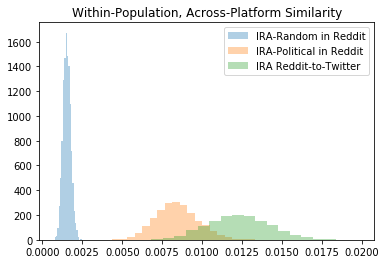

In [113]:
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA-Random in Reddit")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA-Political in Reddit")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA Reddit-to-Twitter")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()

In [114]:
# Test whether the across-platform similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(r2t_rand_sim_avg_bootstrap, r2t_poli_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2t_rand_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between Random and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2t_poli_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 2628356.536907028
p-value for Welch's t-Test between Random and IRA: 0.0 -279.1638743635126
p-value for Welch's t-Test between Poli and IRA: 0.0 1502.8919347616768


In [115]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

# t_stat, p_val = scipy.stats.ttest_ind(
#     r2r_poli_poli_sim_avg_bootstrap, 
#     r2r_ira_ira_sim_avg_bootstrap, 
#     axis=0, equal_var=False)
# print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 150665.514581946
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -360.50303534205517


In [116]:
## Full Cross-Comparison

### Other comparisons
t2t_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_poli_sim_avg, replace=True, n_samples=t2t_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_poli_sim_avg, replace=True, n_samples=r2r_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]




In [117]:
print("\t", "Random", "\t\t", "Political", "\t\t", "IRA", "\t\t", "Other")
print("\t", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2")

print("Reddit")
print("Random:", 
    np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_rand_sim_avg_bootstrap).var(),
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2t_rand_sim_avg_bootstrap).mean(), 
    np.array(r2t_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_poli_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2t_poli_sim_avg_bootstrap).mean(), 
    np.array(r2t_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_ira_sim_avg_bootstrap).var(),
    np.array(r2t_ira_sim_avg_bootstrap).mean(), 
    np.array(r2t_ira_sim_avg_bootstrap).var(),
)

print("Twitter")
print("Random:", 
    np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_rand_sim_avg_bootstrap).var(),
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2r_rand_sim_avg_bootstrap).mean(), 
    np.array(t2r_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_poli_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2r_poli_sim_avg_bootstrap).mean(), 
    np.array(t2r_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_ira_sim_avg_bootstrap).var(),
    np.array(t2r_ira_sim_avg_bootstrap).mean(), 
    np.array(t2r_ira_sim_avg_bootstrap).var(),
)


	 Random 		 Political 		 IRA 		 Other
	 mu sigma^2 mu sigma^2 mu sigma^2 mu sigma^2
Reddit
Random: 0.0005662284746729251 2.1720997658711565e-09 0.004030109580908564 5.5364170294141124e-08 0.0015363661775850096 5.745654346953049e-08 0.004557978618366617 7.540260660532135e-08
Political: 0.004030109580908564 5.5364170294141124e-08 0.023275211389360322 2.2545203950605262e-07 0.008424425660051126 1.7675274639154088e-06 0.062312058479183814 1.7355684637178517e-06
IRA: 0.0015363661775850096 5.745654346953049e-08 0.008424425660051126 1.7675274639154088e-06 0.004570026271319696 4.036311583628085e-07 0.012325321121749047 3.794585359303397e-06
Twitter
Random: 0.033210139542131985 3.517008769743961e-07 0.07691187673361732 2.008383028967417e-06 0.03285507891357378 7.984939090737661e-07 0.0045552126393749335 7.283021368288754e-09
Political: 0.07691187673361732 2.008383028967417e-06 0.1885921017287461 2.1337795539841753e-06 0.07429991944833271 4.110571547229148e-06 0.06232570152719456 2.1003132779445

In [118]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 79644.93058222823
p-value for Welch's t-Test : 0.0 388.66501168999264
p-value for Welch's t-Test : 0.0 116.9461646751064


### Compare Identically Named Users

In [144]:
reddit_troll_names = pd.read_csv("../data/reddit_troll_accounts_20190206.csv")
twitter_troll_names = pd.read_csv("../data/twitter_russian_troll_accounts.csv")

In [148]:
cross_platform_users = set(twitter_troll_names["handle"].apply(str.lower))\
    .intersection(set(reddit_troll_names["username"].apply(str.lower)))

print("User count with the same ID:", len(cross_platform_users))
for u in cross_platform_users:
    print(u)

User count with the same ID: 19
markhudson89
dorothiebell
jenn_abrams
tebepizdec
rebekahbennet
deusxyx
wadeharriot
bleepthepolice
stephenbag
toneporter
fuuncake
leecory
blacktolive
matevidence
southlonestar
ten_gop
hyddrox
mr_clampin
1488reasons


In [149]:
deanon_df = pd.read_csv("../data/deanon_v2.csv")

In [151]:
deanon_map = {row["screen_name"].lower():row["userid"] for _, row in deanon_df.iterrows()}

In [184]:
for u in cross_platform_users:
    print(u, deanon_map.get(u))
    

markhudson89 None
dorothiebell dfcf2c9017b25c825fa444e17e429f3a6e739bc44ca7db41645470fe4410ad25
jenn_abrams None
tebepizdec None
rebekahbennet None
deusxyx 99299a75c967aa491b27d86a60c2ffe0a6156d1b0dcb4487917f48e7e1c7ef78
wadeharriot 349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869
bleepthepolice None
stephenbag None
toneporter cd2f120a1666c87fac2ab045e1ff01b06be0814481d4e96234a13041b3a1a295
fuuncake None
leecory None
blacktolive None
matevidence None
southlonestar None
ten_gop None
hyddrox 396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e
mr_clampin b61d47c22efd69b47675c296d5c54e2675da8977504225327611713990b4e784
1488reasons None


In [187]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    print(u, deanon_map.get(u))
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_links_df_ira[reddit_links_df_ira["user_name"] == u]
    local_twitter_df = twitter_links_df_ira[twitter_links_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["tld"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["tld"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)
    print("\t", "Twitter TLDs:", len(local_twitter_tld), "Reddit TLDs:", len(local_reddit_tld))
    print("\t", "TLDs in Common:", len(common_tlds))

    if ( len(common_tlds) == 0 ):
        continue
        
    local_sim = sklearn.metrics.pairwise.cosine_similarity(
        links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
        links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
    print("\t", "Local Similarity:", local_sim)

markhudson89 None
dorothiebell dfcf2c9017b25c825fa444e17e429f3a6e739bc44ca7db41645470fe4410ad25
	 Twitter TLDs: 480 Reddit TLDs: 0
	 TLDs in Common: 0
jenn_abrams None
tebepizdec None
rebekahbennet None
deusxyx 99299a75c967aa491b27d86a60c2ffe0a6156d1b0dcb4487917f48e7e1c7ef78
	 Twitter TLDs: 305 Reddit TLDs: 0
	 TLDs in Common: 0
wadeharriot 349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869
	 Twitter TLDs: 502 Reddit TLDs: 9
	 TLDs in Common: 8
	 Local Similarity: [[0.80427297]]
bleepthepolice None
stephenbag None
toneporter cd2f120a1666c87fac2ab045e1ff01b06be0814481d4e96234a13041b3a1a295
	 Twitter TLDs: 47 Reddit TLDs: 14
	 TLDs in Common: 2
	 Local Similarity: [[1.]]
fuuncake None
leecory None
blacktolive None
matevidence None
southlonestar None
ten_gop None
hyddrox 396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e
	 Twitter TLDs: 1386 Reddit TLDs: 12
	 TLDs in Common: 9
	 Local Similarity: [[0.54646406]]
mr_clampin b61d47c22efd69b47675c296d5c54e2675da897

In [189]:
for u in cross_platform_users:
    hashed_u = deanon_map.get(u)
    
    if ( hashed_u is None ):
        continue
    
    local_reddit_df = reddit_links_df_ira[reddit_links_df_ira["user_name"] == u]
    local_twitter_df = twitter_links_df_ira[twitter_links_df_ira["user_id"] == hashed_u]

    local_reddit_tld = set(local_reddit_df["tld"].value_counts().index)
    local_twitter_tld = set(local_twitter_df["tld"].value_counts().index)

    common_tlds = set(local_twitter_tld).intersection(local_reddit_tld)

    sim = 0.0
    if ( len(common_tlds) > 0 ):
        local_sim = sklearn.metrics.pairwise.cosine_similarity(
            links_to_norm_matrix(local_reddit_df, common_tlds, "user_name"), 
            links_to_norm_matrix(local_twitter_df, common_tlds, "user_id"))
        sim = local_sim[0]
        
    print("%s & %d & %d & %d & %f \\\\" % (u, len(local_reddit_tld), len(local_twitter_tld), len(common_tlds), sim))
    

dorothiebell & 0 & 480 & 0 & 0.000000 \\
deusxyx & 0 & 305 & 0 & 0.000000 \\
wadeharriot & 9 & 502 & 8 & 0.804273 \\
toneporter & 14 & 47 & 2 & 1.000000 \\
hyddrox & 12 & 1386 & 9 & 0.546464 \\
mr_clampin & 9 & 72 & 0 & 0.000000 \\


# YouTube Channel Distributions

We've checked the differences in top-level domain sharing, but we know YouTube was very popular as well. Now, we turn to the distributions of YouTube channels.

In [122]:
twitter_yt_df_rand = twitter_links_df_rand[twitter_links_df_rand.tld == "youtube.com"].copy()
twitter_yt_df_poli = twitter_links_df_poli[twitter_links_df_poli.tld == "youtube.com"].copy()
twitter_yt_df_ira = twitter_links_df_ira[twitter_links_df_ira.tld == "youtube.com"].copy()

twitter_yt_df_rand["video_id"] = twitter_yt_df_rand.link.apply(strip_video_id_from_url)
twitter_yt_df_poli["video_id"] = twitter_yt_df_poli.link.apply(strip_video_id_from_url)
twitter_yt_df_ira["video_id"] = twitter_yt_df_ira.link.apply(strip_video_id_from_url)

twitter_yt_df_rand = twitter_yt_df_rand.dropna(subset=["video_id"])
twitter_yt_df_poli = twitter_yt_df_poli.dropna(subset=["video_id"])
twitter_yt_df_ira = twitter_yt_df_ira.dropna(subset=["video_id"])


In [123]:
twitter_video_ids = set(twitter_yt_df_rand["video_id"]).union(set(twitter_yt_df_poli["video_id"])).union(set(twitter_yt_df_ira["video_id"]))
print("Unique YT Videos:", len(twitter_video_ids))

with open("twitter_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in twitter_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        out_file.write("%s\n" % video_id)

Unique YT Videos: 154835


In [124]:
reddit_yt_df_rand = reddit_links_df_rand[reddit_links_df_rand.tld == "youtube.com"].copy()
reddit_yt_df_poli = reddit_links_df_poli[reddit_links_df_poli.tld == "youtube.com"].copy()
reddit_yt_df_ira = reddit_links_df_ira[reddit_links_df_ira.tld == "youtube.com"].copy()

reddit_yt_df_rand["video_id"] = reddit_yt_df_rand.link.apply(strip_video_id_from_url)
reddit_yt_df_poli["video_id"] = reddit_yt_df_poli.link.apply(strip_video_id_from_url)
reddit_yt_df_ira["video_id"] = reddit_yt_df_ira.link.apply(strip_video_id_from_url)

reddit_yt_df_rand = reddit_yt_df_rand.dropna(subset=["video_id"])
reddit_yt_df_poli = reddit_yt_df_poli.dropna(subset=["video_id"])
reddit_yt_df_ira = reddit_yt_df_ira.dropna(subset=["video_id"])


In [125]:
reddit_video_ids = set(reddit_yt_df_rand["video_id"]).union(set(reddit_yt_df_poli["video_id"])).union(set(reddit_yt_df_ira["video_id"]))
print("Unique YT Videos:", len(reddit_video_ids))

with open("reddit_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in reddit_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        video_id = video_id.replace("%", "")
        out_file.write("%s\n" % video_id)

Unique YT Videos: 50348


In [126]:
all_video_ids = reddit_video_ids.union(twitter_video_ids)
print("Merged YT Videos:", len(all_video_ids))

with open("twitter+reddit_all_video_ids.csv", "w") as out_file:
    out_file.write("video_id\n")
    for video_id in all_video_ids:
        if ( len(video_id.strip()) == 0 ):
            continue
        out_file.write("%s\n" % video_id)

Merged YT Videos: 202324


In [127]:

twitter_yt_meta_df = pd.read_csv("twitter_video_metadata.csv")
twitter_yt_vid2chan_map = {row["video_id"]:row["channel_id"] for idx, row in twitter_yt_meta_df.iterrows()}

twitter_yt_df_rand["channel_id"] = twitter_yt_df_rand["video_id"].apply(twitter_yt_vid2chan_map.get)
twitter_yt_df_poli["channel_id"] = twitter_yt_df_poli["video_id"].apply(twitter_yt_vid2chan_map.get)
twitter_yt_df_ira["channel_id"] = twitter_yt_df_ira["video_id"].apply(twitter_yt_vid2chan_map.get)

twitter_top_yt_chans_rand = get_top_channels(twitter_yt_df_rand, user_id_field="user_id", top_n=top_n_channels)
twitter_top_yt_chans_poli = get_top_channels(twitter_yt_df_poli, user_id_field="user_id", top_n=top_n_channels)
twitter_top_yt_chans_ira = get_top_channels(twitter_yt_df_ira, user_id_field="user_id", top_n=top_n_channels)

top_yt_chans_map_twitter = {
    "random": set(twitter_top_yt_chans_rand),
    "political": set(twitter_top_yt_chans_poli),
    "ira": set(twitter_top_yt_chans_ira),
}

for population, tlds in top_yt_chans_map_twitter.items():
    print(population, ":", len(tlds))

# twitter_merged_yt_chans = set(twitter_top_yt_chans_rand)\
#     .intersection(twitter_top_yt_chans_poli)
# #     .intersection(twitter_top_yt_chans_ira)
# print("Merged Top Channels:", len(twitter_merged_yt_chans))



random : 250
political : 250
ira : 250


In [128]:

reddit_yt_meta_df = pd.read_csv("reddit_all_video_metadata.csv")
reddit_yt_vid2chan_map = {row["video_id"]:row["channel_id"] for idx, row in reddit_yt_meta_df.iterrows()}

reddit_yt_df_rand["channel_id"] = reddit_yt_df_rand["video_id"].apply(reddit_yt_vid2chan_map.get)
reddit_yt_df_poli["channel_id"] = reddit_yt_df_poli["video_id"].apply(reddit_yt_vid2chan_map.get)
reddit_yt_df_ira["channel_id"] = reddit_yt_df_ira["video_id"].apply(reddit_yt_vid2chan_map.get)

reddit_top_yt_chans_rand = get_top_channels(reddit_yt_df_rand, user_id_field="user_name", top_n=top_n_channels)
reddit_top_yt_chans_poli = get_top_channels(reddit_yt_df_poli, user_id_field="user_name", top_n=top_n_channels)
reddit_top_yt_chans_ira = get_top_channels(reddit_yt_df_ira, user_id_field="user_name", top_n=top_n_channels)

top_yt_chans_map_reddit = {
    "random": set(reddit_top_yt_chans_rand),
    "political": set(reddit_top_yt_chans_poli),
    "ira": set(reddit_top_yt_chans_ira),
}

for population, tlds in top_yt_chans_map_reddit.items():
    print(population, ":", len(tlds))

# reddit_merged_yt_chans = set(reddit_top_yt_chans_rand)\
#     .intersection(reddit_top_yt_chans_poli)
# #     .intersection(reddit_top_yt_chans_ira)
# print("Merged Top Channels:", len(reddit_merged_yt_chans))




random : 250
political : 250
ira : 127


In [129]:
# all_top_channels = reddit_merged_yt_chans.intersection(twitter_merged_yt_chans)
# print("Cross-Platform Top Channels:", len(all_top_channels))

In [130]:
# channels = sorted(all_top_channels)

Rand->Poli Overlap: 107
Rand->IRA Overlap: 34
Poli->IRA Overlap: 41


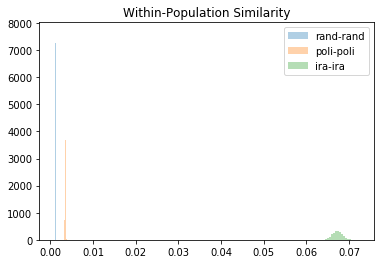

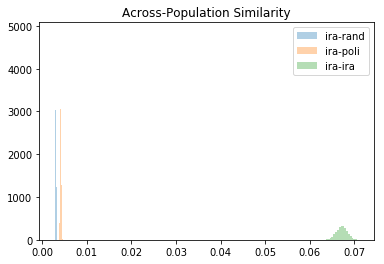

In [131]:
twitter_overlap_rand_poli = top_yt_chans_map_twitter["random"].intersection(top_yt_chans_map_twitter["political"])
twitter_overlap_rand_ira = top_yt_chans_map_twitter["random"].intersection(top_yt_chans_map_twitter["ira"])
twitter_overlap_poli_ira = top_yt_chans_map_twitter["political"].intersection(top_yt_chans_map_twitter["ira"])

print("Rand->Poli Overlap:", len(twitter_overlap_rand_poli))
print("Rand->IRA Overlap:", len(twitter_overlap_rand_ira))
print("Poli->IRA Overlap:", len(twitter_overlap_poli_ira))

twitter_user_links_mat_rand = channels_to_norm_matrix(twitter_yt_df_rand, top_yt_chans_map_twitter["random"], "user_id")
twitter_user_links_mat_poli = channels_to_norm_matrix(twitter_yt_df_poli, top_yt_chans_map_twitter["political"], "user_id")
twitter_user_links_mat_ira = channels_to_norm_matrix(twitter_yt_df_ira, top_yt_chans_map_twitter["ira"], "user_id")

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_ira, twitter_overlap_rand_ira, "user_id"), 
    channels_to_norm_matrix(twitter_yt_df_rand, twitter_overlap_rand_ira, "user_id"))
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_ira, twitter_overlap_poli_ira, "user_id"), 
    channels_to_norm_matrix(twitter_yt_df_poli, twitter_overlap_poli_ira, "user_id"))
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(twitter_yt_df_rand, twitter_overlap_rand_poli, "user_id"), 
    channels_to_norm_matrix(twitter_yt_df_poli, twitter_overlap_rand_poli, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_ira_sim_avg = (np.sum(t2t_ira_ira_sim, axis=1) - 1) / (twitter_user_links_mat_ira.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)
t2t_rand_poli_sim_avg = np.mean(t2t_rand_poli_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(t2t_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(t2t_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(t2t_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

Rand->Poli Overlap: 70
Rand->IRA Overlap: 8
Poli->IRA Overlap: 18


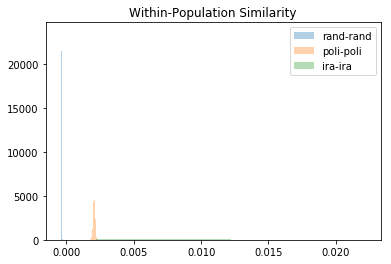

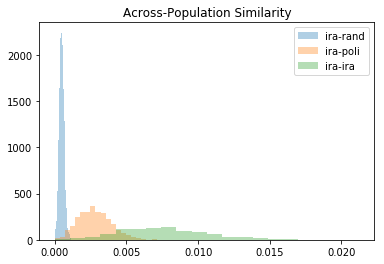

In [132]:
reddit_overlap_rand_poli = top_yt_chans_map_reddit["random"].intersection(top_yt_chans_map_reddit["political"])
reddit_overlap_rand_ira = top_yt_chans_map_reddit["random"].intersection(top_yt_chans_map_reddit["ira"])
reddit_overlap_poli_ira = top_yt_chans_map_reddit["political"].intersection(top_yt_chans_map_reddit["ira"])

print("Rand->Poli Overlap:", len(reddit_overlap_rand_poli))
print("Rand->IRA Overlap:", len(reddit_overlap_rand_ira))
print("Poli->IRA Overlap:", len(reddit_overlap_poli_ira))

reddit_user_links_mat_rand = channels_to_norm_matrix(reddit_yt_df_rand, top_yt_chans_map_twitter["random"], "user_name")
reddit_user_links_mat_poli = channels_to_norm_matrix(reddit_yt_df_poli, top_yt_chans_map_twitter["political"], "user_name")
reddit_user_links_mat_ira = channels_to_norm_matrix(reddit_yt_df_ira, top_yt_chans_map_twitter["ira"], "user_name")

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_ira, reddit_overlap_rand_ira, "user_name"), 
    channels_to_norm_matrix(reddit_yt_df_rand, reddit_overlap_rand_ira, "user_name"))
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_ira, reddit_overlap_poli_ira, "user_name"), 
    channels_to_norm_matrix(reddit_yt_df_poli, reddit_overlap_poli_ira, "user_name"))
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_rand, reddit_overlap_rand_poli, "user_name"), 
    channels_to_norm_matrix(reddit_yt_df_poli, reddit_overlap_rand_poli, "user_name"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_ira_sim_avg = (np.sum(r2r_ira_ira_sim, axis=1) - 1) / (reddit_user_links_mat_ira.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)
r2r_rand_poli_sim_avg = np.mean(r2r_rand_poli_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(r2r_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(r2r_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(r2r_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

Random Overlap: 73
Political Overlap: 127
IRA Overlap: 8


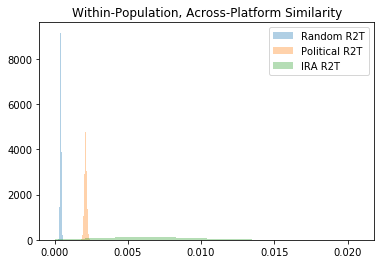

In [133]:
r2t_overlap_rand = top_yt_chans_map_reddit["random"].intersection(top_yt_chans_map_twitter["random"])
r2t_overlap_poli = top_yt_chans_map_reddit["political"].intersection(top_yt_chans_map_twitter["political"])
r2t_overlap_ira = top_yt_chans_map_reddit["ira"].intersection(top_yt_chans_map_twitter["ira"])

print("Random Overlap:", len(r2t_overlap_rand))
print("Political Overlap:", len(r2t_overlap_poli))
print("IRA Overlap:", len(r2t_overlap_ira))

# Calculate pairwise similarity among users across platforms
r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_rand, r2t_overlap_rand, "user_name"), 
    channels_to_norm_matrix(twitter_yt_df_rand, r2t_overlap_rand, "user_id"))
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_poli, r2t_overlap_poli, "user_name"), 
    channels_to_norm_matrix(twitter_yt_df_poli, r2t_overlap_poli, "user_id"))
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(
    channels_to_norm_matrix(reddit_yt_df_ira, r2t_overlap_ira, "user_name"), 
    channels_to_norm_matrix(twitter_yt_df_ira, r2t_overlap_ira, "user_id"))

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()



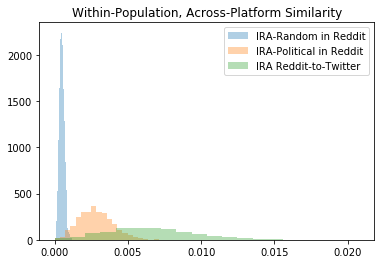

In [134]:
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA-Random in Reddit")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA-Political in Reddit")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA Reddit-to-Twitter")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()

In [136]:
## Full Cross-Comparison

### Other comparisons
t2t_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_poli_sim_avg, replace=True, n_samples=t2t_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_rand_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_poli_sim_avg, replace=True, n_samples=r2r_rand_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]


In [137]:
print("\t", "Random", "\t\t", "Political", "\t\t", "IRA", "\t\t", "Other")
print("\t", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2", "mu", "sigma^2")

print("Reddit")
print("Random:", 
    np.array(r2r_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_rand_sim_avg_bootstrap).var(),
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2t_rand_sim_avg_bootstrap).mean(), 
    np.array(r2t_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(r2r_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_rand_poli_sim_avg_bootstrap).var(),
    np.array(r2r_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_poli_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2t_poli_sim_avg_bootstrap).mean(), 
    np.array(r2t_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(r2r_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_rand_sim_avg_bootstrap).var(),
    np.array(r2r_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_poli_sim_avg_bootstrap).var(),
    np.array(r2r_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(r2r_ira_ira_sim_avg_bootstrap).var(),
    np.array(r2t_ira_sim_avg_bootstrap).mean(), 
    np.array(r2t_ira_sim_avg_bootstrap).var(),
)

print("Twitter")
print("Random:", 
    np.array(t2t_rand_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_rand_sim_avg_bootstrap).var(),
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2r_rand_sim_avg_bootstrap).mean(), 
    np.array(t2r_rand_sim_avg_bootstrap).var(),
)

print("Political:", 
    np.array(t2t_rand_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_rand_poli_sim_avg_bootstrap).var(),
    np.array(t2t_poli_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_poli_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2r_poli_sim_avg_bootstrap).mean(), 
    np.array(t2r_poli_sim_avg_bootstrap).var(),
)

print("IRA:", 
    np.array(t2t_ira_rand_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_rand_sim_avg_bootstrap).var(),
    np.array(t2t_ira_poli_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_poli_sim_avg_bootstrap).var(),
    np.array(t2t_ira_ira_sim_avg_bootstrap).mean(), 
    np.array(t2t_ira_ira_sim_avg_bootstrap).var(),
    np.array(t2r_ira_sim_avg_bootstrap).mean(), 
    np.array(t2r_ira_sim_avg_bootstrap).var(),
)



	 Random 		 Political 		 IRA 		 Other
	 mu sigma^2 mu sigma^2 mu sigma^2 mu sigma^2
Reddit
Random: -0.0003532601204323369 2.8221713135319326e-10 0.0005223273681660242 2.3683151796636034e-09 0.0004913481042478745 2.849303927776604e-08 0.000422313612642227 1.8392335735375566e-09
Political: 0.0005223273681660242 2.3683151796636034e-09 0.002057099366260814 7.222594778843699e-09 0.0028226648621384365 1.3497762011078173e-06 0.002111734062324402 7.023358354896392e-09
IRA: 0.0004913481042478745 2.849303927776604e-08 0.0028226648621384365 1.3497762011078173e-06 0.007554077418338818 9.718791670061101e-06 0.006613322152074352 8.909184211825693e-06
Twitter
Random: 0.0011969285853934333 2.970896508071694e-09 0.0021258169493298504 8.724719578271375e-09 0.003090738052246145 6.642124196019051e-09 0.0045552126393749335 7.283021368288754e-09
Political: 0.0021258169493298504 8.724719578271375e-09 0.003490020007716967 8.85901379362546e-09 0.004145570942993259 1.710855793733421e-08 0.06232570152719456 2.10

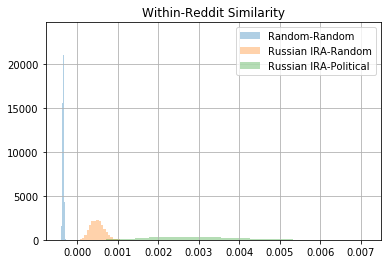

In [192]:
plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [138]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2r_rand_rand_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 29436.06730302598
p-value for Welch's t-Test : 0.0 -140.40281715521255


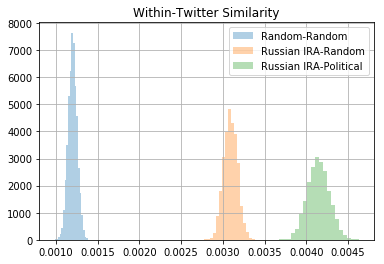

In [193]:
plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random-Random")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Within-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [194]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2t_rand_rand_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 1252826.4068125677
p-value for Welch's t-Test : 0.0 -483.93517241158554


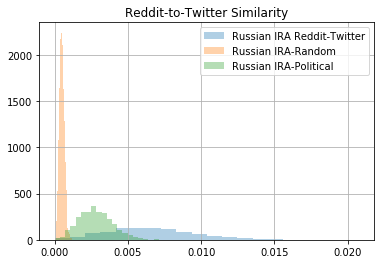

In [195]:
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Reddit-Twitter")
plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Reddit-to-Twitter Similarity")
plt.legend()
plt.grid()
plt.show()

In [196]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    r2r_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap, 
    r2r_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    r2t_ira_sim_avg_bootstrap,
    r2r_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 13917.737389121463
p-value for Welch's t-Test : 0.0 144.78404928288646
p-value for Welch's t-Test : 0.0 83.67667476551861


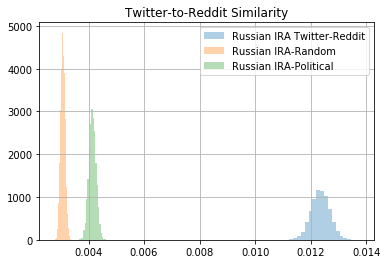

In [197]:
plt.hist(t2r_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA Twitter-Reddit")
plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Random")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Russian IRA-Political")

plt.title("Twitter-to-Reddit Similarity")
plt.legend()
plt.grid()
plt.show()

In [198]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    t2t_ira_poli_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap, 
    t2t_ira_rand_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(
    t2r_ira_sim_avg_bootstrap,
    t2t_ira_poli_sim_avg_bootstrap, 
    axis=0, equal_var=False)
print("p-value for Welch's t-Test :", p_val, t_stat)

p-value for ANOVA: 0.0 2830725.3421387593
p-value for Welch's t-Test : 0.0 1897.7639022124115
p-value for Welch's t-Test : 0.0 1612.0848375645817


In [135]:
channel_map_reddit = {row["channel_id"]:row["channel_title"] for _, row in reddit_yt_meta_df.iterrows()}
channel_map_twitter = {row["channel_id"]:row["channel_title"] for _, row in twitter_yt_meta_df.iterrows()}

print(len(top_yt_chans_map_reddit["ira"]), len(top_yt_chans_map_twitter["ira"]))
print("*"*100, "\nReddit:")
for x in sorted(top_yt_chans_map_reddit["ira"]):
    print(x, channel_map_reddit[x])
    
print("*"*100, "\nTwitter:")
for x in sorted(top_yt_chans_map_twitter["ira"]):
    print(x, channel_map_twitter[x])

127 250
**************************************************************************************************** 
Reddit:
UC07E0MabO1qktuSAwLPYClA Romain Levesque
UC0hkwSIzywVL0Unfh35aVHw Meme Militia
UC0pjFxM6b7fLO4hWZz1XwhA redha redha
UC16niRr50-MSBwiO3YDb3RA BBC News
UC1yBKRuGpC1tSM73A0ZjYjQ The Young Turks
UC2-BeLxzUBSs0uSrmzWhJuQ 20th Century Fox
UC2FUP1CtHRzUYtsFLuQLLMg Changers
UC2UIuUg8jvObCB69SVKim5w Amy Slack
UC2VnwPCW63NH9YTLvZj9qKA Charles Gaba
UC2YnEq5Fc5_zEO6bo0oNzCQ melanie martinez
UC3HvwOPH-xwVb1aWoVg7ohg 8BitDylan
UC49JMhfP3JaJlWoZru2hhUw Keep Up With The News
UC4UyF8vu2-QybvSMV07ZsbQ LifeMoments247
UC6ZFN9Tx6xh-skXCuRHCDpQ PBS NewsHour
UC6smmr3qaBCGztOoLoM_aSQ paultyree1
UC6xM7GvKd85duq5fw8qKBOQ Matt Orfalea
UC6ybAZHANiMTbaQAOO-_0wQ animal lovers
UC7TvL4GlQyMBLlUsTrN_C4Q corbettreport
UC7v3-2K1N84V67IF-WTRG-Q Jeremy Jahns
UC7ygjE6Dmi0PBI5NuYj0x4g dailymailofficial24x7
UC8jD-AUseXkAQqfYW9vl8mw Super Epic Cats
UC9obdDRxQkmn_4YpcBMTYLw Tiger FunnyWorks
UCADX_BwgeiTFlnkg6tm